# Word2Vec: from preprocessing to vector exploration

Notebook adapted from my lecture on Word2Vec held at the Digital Humanities at Oxford Summer School (DHOxSS) in 2022.

## Preprocessing

Many different choices can be made when preprocessing a corpus to be used as Word2Vec training data. Ultimately the choices you'll make will usually depend on:

1. The size of your corpus (it might be computationally too expensive to heavily preprocess very large corpora: choose a quality-time trade-off wisely!)
2. What you are planning to use the model for (e.g. maybe you want to look at non-lemmatized tokens? Maybe you'd like to keep numbers?)

For this first complete example, our preprocessing will consist of:
- Lowercasing
- Punctuation removal
- Stopword removal
- Lemmatization

But preprocessing may also include tasks like:
- Removal of tokens with less than _n_ characters
- Removal of numbers
- PoS tagging

In [1]:
import spacy

Load the English model `en_core_web_sm` from `spacy`:

In [2]:
nlp = spacy.load('en_core_web_sm')

The following shows what a preprocessed sentences looks like. To preprocess texts using `spacy`, we can use various built-in methods after having loaded the English model.

In [3]:
sentence = 'These are test sentences, just to have a look at how a processed sentence looks like'

# create Spacy Doc object
doc = nlp(sentence)

# tokenize, lemmatize (.lemma_), remove stopwords (.is_stop) and punctuation (.isalpha())
tokenized_sentence = [token.lemma_ for token in doc if token.is_stop == False and token.text.isalpha() == True]

tokenized_sentence

['test', 'sentence', 'look', 'process', 'sentence', 'look', 'like']

## Train a word2vec model

In [41]:
import pandas as pd
from gensim.models import Word2Vec
from tqdm import tqdm # To track the progress of loops

Now let's initialize Word2Vec defining some hyperparameters.
[Here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) is a breakdown of all possible HP which can be changed. We'll mostly stick to the defaults (but spell out the most important ones for clarity):

In [5]:
# !mkdir data
# !wget -O data/newspapers-toy.csv https://raw.githubusercontent.com/Living-with-machines/dhoxss-text2tech/npedrazzini-word2vecsesh/Sessions/data/newspapers-toy.csv 

mkdir: data: File exists


--2023-10-26 20:45:12--  https://raw.githubusercontent.com/Living-with-machines/dhoxss-text2tech/npedrazzini-word2vecsesh/Sessions/data/newspapers-toy.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254889 (249K) [text/plain]
Saving to: ‘data/newspapers-toy.csv’

data/newspapers-toy 100%[===================>] 248.92K  --.-KB/s    in 0.05s   

2023-10-26 20:45:12 (4.42 MB/s) - ‘data/newspapers-toy.csv’ saved [254889/254889]



In [6]:
incsv = pd.read_csv('./data/newspapers-toy.csv')
incsv.head()

,NLP,issue,art_num,title,collection,full_date,year,month,day,location,word_count,ocrquality,text,decade
0,2083,704,art0025,The Northern Daily Times.,British Library Heritage Made Digital Newspapers,1856-07-04,1856,7,4,"Liverpool, Merseyside, England",3019,0.9516,"THE KING OF NAPLES, A letter from Paris asser...",1850
1,2083,704,art0029,The Northern Daily Times.,British Library Heritage Made Digital Newspapers,1856-07-04,1856,7,4,"Liverpool, Merseyside, England",474,0.9366,VEGETABLES Best collection of vegetables (six...,1850
2,2083,704,art0024,The Northern Daily Times.,British Library Heritage Made Digital Newspapers,1856-07-04,1856,7,4,"Liverpool, Merseyside, England",2,0.9450,LATEST INTELLIGENCE.,1850
3,2083,704,art0031,The Northern Daily Times.,British Library Heritage Made Digital Newspapers,1856-07-04,1856,7,4,"Liverpool, Merseyside, England",697,0.9658,MURDER IN WORCESTERSHIRE A shocking murder ha...,1850
4,2083,704,art0033,The Northern Daily Times.,British Library Heritage Made Digital Newspapers,1856-07-04,1856,7,4,"Liverpool, Merseyside, England",4520,0.9371,"POLICE COURT -YESTERDAY (BEFORE MR,. MANSFIEL...",1850


In [7]:
sentences = []

for sentence in tqdm(incsv['text']):
    # create Spacy Doc object
    doc = nlp(sentence.lower()) # lowercase first and convert sentence to spacy Doc object

    # tokenize, lemmatize (.lemma_), remove stopwords (.is_stop) and punctuation (.isalpha())
    tokenized_sentence = [token.lemma_ for token in doc if token.is_stop == False and token.text.isalpha() == True]
    sentences.append(tokenized_sentence)

sentences[0][0:10] # Show first sentence

100%|██████████| 49/49 [00:08<00:00,  5.83it/s]


['king',
 'naples',
 'letter',
 'paris',
 'assert',
 'king',
 'naples',
 'transmit',
 'unfavourable',
 'reply']

We first initialize our Word2Vec model, i.e. we first simply define the skeleton of our model, without giving it data to learn from. In practical terms, this means pre-specifying the **parameters** which we want to use. 

There are many parameters one can specify, the full list of which is [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec). 

However note that it's okay to start with the default ones (which you can find specified in the link just provided, e.g. min_count = 5), which correspond to the ones that were found by several studies to be optimal for many different tasks. 

Normally, it is good practice to find the **optimal parameters** for your model, or better still, for the purpose for which you plan to use your model. 

For example, a higher window of words, i.e. the parameter `window`, will make the model consider more words before and after each token when calculating the vector for each word in the corpus: this seems to lead the model to capture more semantic similarities/relationships, whereas a smaller window will tend to reflect similarities which are more syntactic in nature.


In [8]:
w2v_model = Word2Vec(min_count=5, # how often a word should appear to be included
                    window=5, # how many words before and after count as context
                    sg=1, # SkipGram? 0 = False, 1 = True Else: CBoW. Note: Default is 0
                    vector_size=100) 

Building the vocabulary is an obligatory step:

In [9]:
w2v_model.build_vocab(sentences) # Build vocabulary

We then train the model as follows:

In [10]:
w2v_model.train(sentences, 
                total_examples=w2v_model.corpus_count,
                epochs=5)

(54906, 97085)

We will now save both the whole model and the vectors only. This is because, while a file containing only the vectors is easier to manage, saving the model as well allows you to update it in the future (e.g. to train it on more relevant sentences). Note: `binary=False` will simply save the vectors in non-binary format, which can take longer to store and process, but easier to deal with.

In [11]:
!mkdir models

mkdir: models: File exists


In [12]:
w2v_model.save("./models/test-model") # Save the full model (in case we'd like to update it in the future)
w2v_model.wv.save_word2vec_format('./models/test-model-vectors.txt', binary=False) # Also save the vectors only (easier to work with) - Not necessary, of course

## Using a pretrained w2v model

In [1]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

The model we just trained was just a sample to give you an idea of what a complete pipeline is like, from preprocessing a corpus to training a word2vec model. It is obviously too small to actually play around with the vectors meaningfully.
We now have a look at how to load a pretrained word2vec model (or pretrained vectors) to explore word similarity, analogy, and more.

Pre-trained models can come as full models, or just as a file containing pretrained vectors. Most pretrained models are vectors-only and full models are generally kept only if one may update the model at some point.

For example, to upload the full model saved in the previous section:

In [14]:
pretrained_model = Word2Vec.load('./models/test-model')

Then we can simply work on its vectors by 'isolating' the vectors in the following way (the result is a dictionary, where keys are words and the value are the vectors, in the form ['word': N1,...Nn, 'word2': N1,...Nn, 'word3': N1,...Nn, ...]):

In [15]:
pretrained_vectors = pretrained_model.wv

For example, to see the vector for the word '**man**', you use the same syntax you'd use to access any value for a given key in a dictionary:

In [16]:
pretrained_vectors['man']

array([-0.12109955,  0.14690332, -0.05147466,  0.06218386, -0.00673043,
       -0.20469017, -0.04526234,  0.3214863 , -0.01137817,  0.04133358,
       -0.115912  , -0.10873254,  0.01959872,  0.0349085 ,  0.04336726,
       -0.14161527,  0.02427126, -0.0552213 , -0.01551427, -0.28973067,
        0.03457584,  0.08382834, -0.08809782,  0.01085639, -0.02925968,
        0.08474035, -0.05213086, -0.15375274,  0.03153659, -0.00427015,
        0.13149251,  0.09879297,  0.12860587, -0.05806441, -0.13872184,
        0.22839813, -0.04200303, -0.20375295, -0.08667108, -0.35300782,
       -0.02085656, -0.2137659 ,  0.0045485 , -0.01405421,  0.15389831,
       -0.0424904 , -0.09130195,  0.06053075,  0.0894789 ,  0.09528551,
        0.10202178, -0.05348302, -0.04141056, -0.02139138, -0.10509287,
        0.24116449,  0.09321243,  0.11988199, -0.23323376,  0.0164039 ,
        0.09043768,  0.12182116,  0.04157947, -0.17422411, -0.11652496,
        0.01812902,  0.00276023,  0.02828199, -0.18886302,  0.11

Of course, one vector alone is pretty useless. Word vectors make sense relatively to each other, so the above is just to show you how you can access the value (= vector) of a specific key (= a word) in your list of vectors.

If the word is not in the vocabulary you'll get an `Error`:

In [18]:
pretrained_vectors['Nilo'] # not in vocabulary

KeyError: "Key 'Nilo' not present"

To upload a file with vectors only, we use the `KeyedVectors` module from `gensim.models`, rather than the `Word2Vec` one:

In [19]:
pretrained_vectors = KeyedVectors.load_word2vec_format('./models/test-model-vectors.txt')

To look at how word vectors can be used to explore similarity, we will use a slightly modified version of the English vectors released for the CoNLL-17 shared task (http://universaldependencies.org/conll17/data.html). This is because the (toy) model we just trained was way too small (only a very small sample from an OCR'd newspaper collection to show you what the whole pipeline from preprocessing to training is like).

Many more (large enough) models can be found [here](https://fasttext.cc/docs/en/pretrained-vectors.html). It is hard to define when 'large' is large enough. As a (very) rough rule of thumb, perhaps **at least** around 500K words are necessary to train embeddings on corpora of a very specific style/genre/topic, and 2-4 million words for somewhat more diverse sources. Ultimately, there is no 'right' number, and perhaps more is not necessarily better (or maybe it is... depending on your corpus and its quality). A good read on the topic is [this one](https://aclanthology.org/W17-6908.pdf).

Note that the choice of the model will have a huge impact on the results you will get, as the similarity/distance between word vectors will obviously reflect the content of the texts on which each model has been trained.

First, load the vectors using `KeyedVectors` (this will take at least a minute):

In [13]:
!wget -O models/conll_vectors.zip http://vectors.nlpl.eu/repository/20/40.zip
!unzip models/conll_vectors.zip -d models/

--2023-10-27 07:36:52--  http://vectors.nlpl.eu/repository/20/40.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3033545506 (2.8G) [application/zip]
Saving to: ‘models/conll_vectors.zip’

models/conll_vector 100%[===================>]   2.83G  16.3MB/s    in 2m 57s  

2023-10-27 07:39:49 (16.3 MB/s) - ‘models/conll_vectors.zip’ saved [3033545506/3033545506]

Archive:  models/conll_vectors.zip
  inflating: models/LIST             
  inflating: models/meta.json        
  inflating: models/model.bin        
  inflating: models/model.txt        
  inflating: models/README           


In [15]:
pretrained_vectors = KeyedVectors.load_word2vec_format('./models/model.txt',unicode_errors='ignore')

Note that it took more than 2 minute to load our vectors. Naturally, the bigger the model, there longer it will take.

### Simple similarity tasks

Based on the loaded `pretrained_vectors`, we can look at the _n_ most similar words to any word, provided the latter is in the vocabulary (if not, it will return an Error). The `gensim` method `.most_similar` will 'compute cosine similarity between a simple mean of the projection weight vectors of the given words and the vectors for each word in the model' ([source](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html)). So: there some maths behind, which you don't need to understand in detail to understand what follows - so don't worry!

Let's start with a simple example.

Get the **10 most similar vectors** to the vector for '**worker**':

In [16]:
pretrained_vectors.most_similar(positive='worker', topn=10)

[('workers', 0.7571247220039368),
 ('employee', 0.7382051944732666),
 ('homeworker', 0.7167433500289917),
 ('dockworker', 0.7048864364624023),
 ('telecommutes', 0.7038429975509644),
 ('jobs—as', 0.69834965467453),
 ('-laborer', 0.6983168721199036),
 ('officerbusiness', 0.6980635523796082),
 ('non-skilled', 0.6966322064399719),
 ('steelworker', 0.6943268179893494)]

> #### <u> **Exercise**! </u>
> Try out the method `.most_similar` for yourself with your word of interest. Write your code below!

In [17]:
# Code here:



We can also combine multiple words as 'positives':

In [18]:
pretrained_vectors.most_similar(positive=['scientist','language'], topn=10)

[('linguist', 0.7805776000022888),
 ('syntactician', 0.7737579345703125),
 ('lincos', 0.7687980532646179),
 ('prlwytzkofsky', 0.7548373937606812),
 ('hyperpolyglot', 0.751720130443573),
 ('language—', 0.7514918446540833),
 ('lingustics', 0.7514796257019043),
 ('phonologist', 0.7513543963432312),
 ('researcher', 0.7505961060523987),
 ('linguistics', 0.7487590909004211)]

> #### <u> **Exercise**! </u>
> Try out the method `.most_similar` combining multiple words of your interest. Write your code below!

In [19]:
# Code here:



Check and compare the similarity between words:

In [20]:
pretrained_vectors.similarity('king', 'queen')

0.8029257

In [21]:
pretrained_vectors.similarity('king', 'prince')

0.77318037

In [22]:
pretrained_vectors.similarity('queen', 'princess')

0.76806784

In [23]:
pretrained_vectors.similarity('queen', 'prince')

0.73086464

In [24]:
pretrained_vectors.similarity('king', 'princess')

0.61721843

In [25]:
pretrained_vectors.similarity('king', 'apple')

0.22277842

Check if the model can find the intruder:

In [26]:
pretrained_vectors.doesnt_match(['apple','peach','pear','pineapple','cat'])

'cat'

We can also try and put the model to test by giving a list with more subtle differences:

In [27]:
pretrained_vectors.doesnt_match(['mother','father','uncle','daughter','son'])

'uncle'

Or:

In [28]:
pretrained_vectors.doesnt_match(['king','queen','president','prince','princess','duke','duchess'])

'president'

> #### <u> **Exercise**! </u>
> Try out the `.doesnt_match` method with your own set of words. Perhaps try putting to test words that have more subtle differences and see if the result from the model agrees with your own intuition. Code below! 

In [29]:
# Code here:



### Word vectors, axes and interpreting distances

When we calculate the cosine similarity between word vectors, behind the scene we are actually using a function that ranks words relatively to one another depending on the size of the angle between any given word vector and each of the others.

The angle is based on the **direction** of the vector only, and it's calculated on the basis of the axes that have 0 as their centre. 

But vectors also have **magnitude** (essentially, a specific length), which sets the maximum value at various distances from 0. 

The (Euclidean) distance between these values for each words can also tell us something in itself. Let's look at some concrete examples.

We will need some tools to visualize the vectors as arrows and points, as well as some tools to work with arrays and to calculate the (Euclidean) distance between points. 

> Don't worry about the details here, this is just to make the concept of word vectors more intuitive through visualization.

In [30]:
from scipy.spatial import distance
import numpy as np
from matplotlib import pyplot as plt

Visualize the vectors for `king`, `queen`, `man` and `woman`:

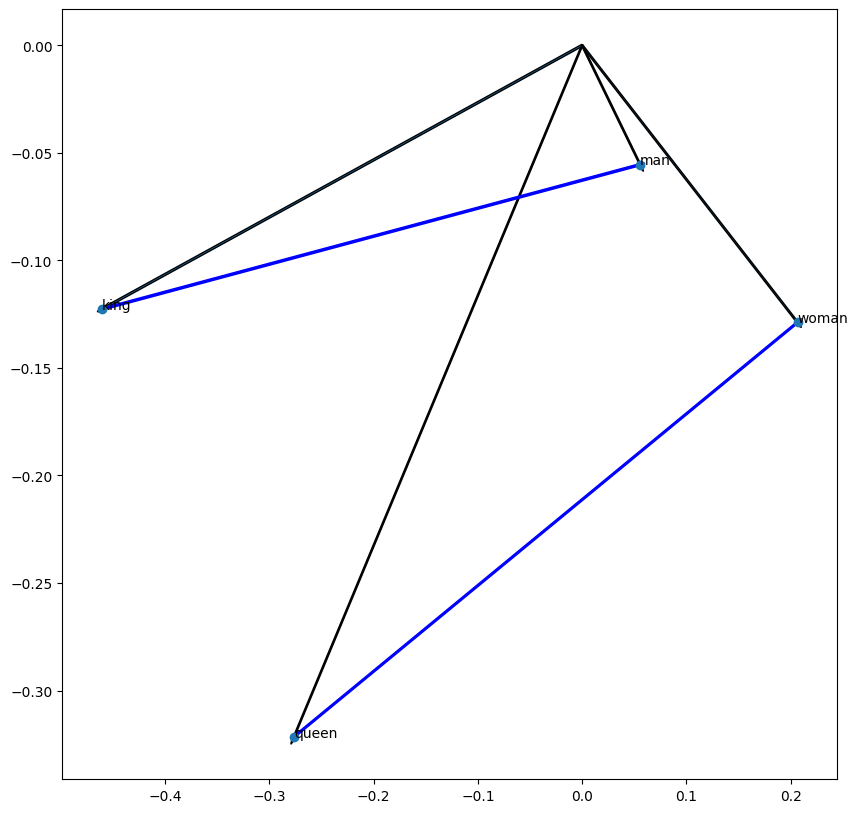

In [31]:
words = ['queen', 'king', 'woman', 'man']
embeddings = np.array([pretrained_vectors[word] for word in words]) # Convert each word to its vector representation
 
fig, ax = plt.subplots(figsize = (10, 10)) # Create custom size image
 
# Represent each vector as arrow (origin is 0)
for word in embeddings:
    ax.arrow(0, 0, word[0], word[1])
     
queen = pretrained_vectors['queen']
king = pretrained_vectors['king']
woman = pretrained_vectors['woman']
man = pretrained_vectors['man']

# Print additional arrows (different color), representing euclidean distance between max(vector)
ax.arrow(queen[0], queen[1], distance.euclidean([woman[0]],[queen[0]]), distance.euclidean([woman[1]],[queen[1]]), fc='b', ec='b')
ax.arrow(king[0], king[1], distance.euclidean([man[0]],[king[0]]), distance.euclidean([man[1]],[king[1]]), fc='b', ec='b')

# Plot a dot for each word
ax.scatter(embeddings[:, 0], embeddings[:, 1])
 
# Add label to dots
for i in range(0, len(words)):
    ax.annotate(words[i], (embeddings[i, 0], embeddings[i, 1]))

As you can see, the angles are smaller between king and queen, and between man and woman, but we can also see that the relationship between king and man is very similar (in length and direction represented by the blue arrow) to that between queen and woman, respectively. This suggests that there's a similar type of relationship between these words in pair, which tells us something different from the cosine similarity.

Let's see another example.
Visualize the vectors for `paris`,`london`,`france` and `england` (two capitals and their country/state):

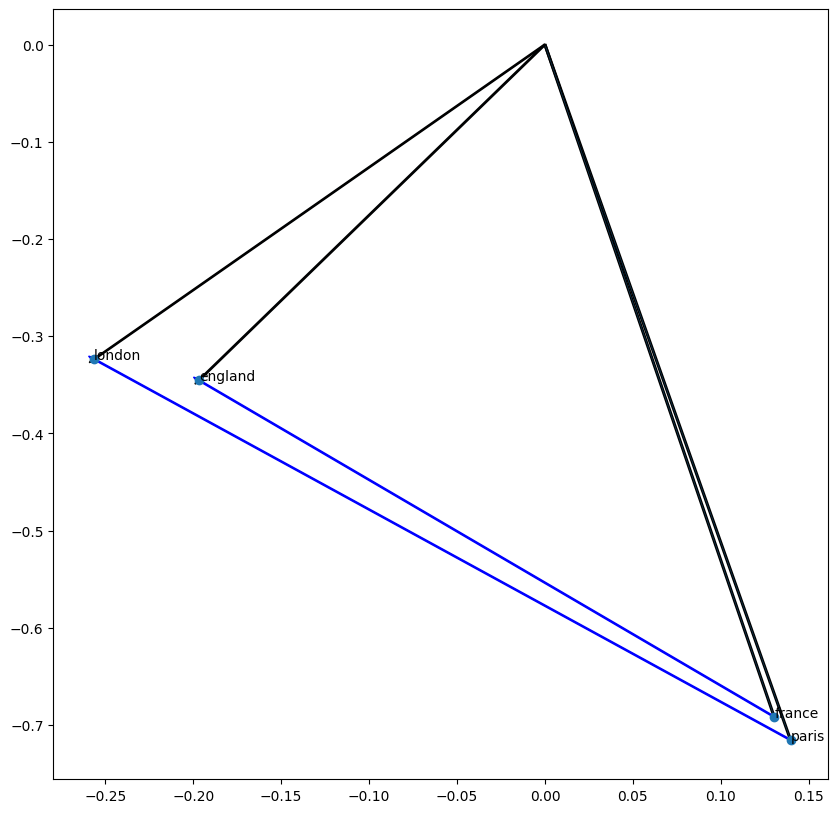

In [32]:
words = ['paris', 'london', 'france', 'england']

embeddings = np.array([pretrained_vectors[word] for word in words]) # Convert each word to its vector representation
 
fig, ax = plt.subplots(figsize = (10, 10)) # Create custom size image
 
# Represent each vector as arrow (origin is 0)
for word in embeddings:
    ax.arrow(0, 0, word[0], word[1]) # take 

paris = pretrained_vectors['paris']
london = pretrained_vectors['london']
france = pretrained_vectors['france']
england = pretrained_vectors['england']

# Print additional arrows (different color), representing euclidean distance between max(vector)
ax.arrow(paris[0], paris[1], -distance.euclidean([london[0]],[paris[0]]), distance.euclidean([london[1]],[paris[1]]), fc='b', ec='b')
ax.arrow(france[0], france[1], -distance.euclidean([england[0]],[france[0]]), distance.euclidean([england[1]],[france[1]]), fc='b', ec='b')

# Plot a dot for each word
ax.scatter(embeddings[:, 0], embeddings[:, 1])
 
# Add label to dots
for i in range(0, len(words)):
    ax.annotate(words[i], (embeddings[i, 0], embeddings[i, 1]))
 

Likewise, we see a similar situation here, even with much more evident differences between angles.

### Vector Arithmetics

Since word vectors are vectors (duh!), we can do maths with them and get interesting results.

A classic: what word is to _woman_ the way _king_ is to _man_? We can try to figure this out by simple additions and subtractions:

`woman + king - man = ?`

In [33]:
pretrained_vectors.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)

[('queen', 0.8487650752067566),
 ('empress', 0.7449748516082764),
 ('debsirindra', 0.7424889206886292),
 ('kamāmalu', 0.733872652053833),
 ('supayalat', 0.7306721806526184),
 ('sambiria', 0.7245728969573975),
 ('stepgrandmother', 0.7228910326957703),
 ('miahuaxihuitl', 0.7212315797805786),
 ('duchess', 0.7206603288650513),
 ('regnant', 0.7181839942932129)]

Or specularly:

`man + queen - woman = ?`

In [34]:
pretrained_vectors.most_similar(positive=['man', 'queen'], negative=['woman'], topn=10)

[('king', 0.8417702913284302),
 ('#king', 0.7328729629516602),
 ('crominus', 0.73011714220047),
 ('andreenos', 0.7160046696662903),
 ('escargoon', 0.7126416563987732),
 ('brahmwell', 0.7118675112724304),
 ('jaehaerys', 0.7043218612670898),
 ('xorbb', 0.7037889361381531),
 ('helmaroc', 0.7033290266990662),
 ('sectonia', 0.7028912901878357)]

This method is often used to find analogies. What is to Paris the way England is to London? Or:

`paris + england - london = ?`

In [35]:
pretrained_vectors.most_similar(positive=['paris', 'england'], negative=['london'])

[('france', 0.8565902709960938),
 ('provence', 0.7728177309036255),
 ('auvergne', 0.7568833231925964),
 ('toulouse', 0.7528023719787598),
 ('rouen', 0.7494249939918518),
 ('poitou', 0.7488312125205994),
 ('marseille', 0.7434563040733337),
 ('fontainebleau', 0.7395411133766174),
 ('nantes', 0.7389647960662842),
 ('perpignan', 0.7357031106948853)]

### Bias in word embeddings

Some of the tasks above involved finding the 'intruder' among terms which are inherently gendered ('uncle', 'daughter', etc.), or finding the vectors closest to the vectors for gendered terms like 'queen' and 'king'. The corpus (and the language, English) contains gender-neutral terms, such as **worker**, **nurse**, **teacher**, **politician**, **beautiful**, **bold**, or **sassy**, which however tend to be heavily stereotyped and associated with specific gender roles in many societies. 

Depending on the the texts the vectors have been trained on, the respective vectors tend to <u>**reflect the bias they have acquired in the natural language**</u> as is represented in the corpus. Bias, of course, can be reflected across several variables (sexual orientation, ethnicity, political leaning, etc.).  

Depending on the task, **this can be an important ethical issue**: it may not be if your model is meant to capture the semantics of words from a specific historical period, but it may be so if the vectors are used to improve certain recommendation systems, for example.


Consider the following:

`? : woman = worker : man` 

or 

`woman + worker - man = ?`

In [36]:
pretrained_vectors.most_similar(positive=['woman', 'worker'], negative=['man'], topn=10)

[('workers', 0.6492294073104858),
 ('motherwoman', 0.6449025273323059),
 ('caseworker', 0.6401273608207703),
 ('nurse', 0.6392772793769836),
 ('employee', 0.6371718049049377),
 ('telecommutes', 0.6279696822166443),
 ('unwed', 0.6266779899597168),
 ('workersa', 0.6244109869003296),
 ('homeworker', 0.6227539777755737),
 ('housecleaner', 0.6208513379096985)]

However consider:

`? : man = worker : woman` 

or:  

`man + worker - woman = ?`

In [37]:
pretrained_vectors.most_similar(positive=['man', 'worker'], negative=['woman'], topn=10)

[('-laborers', 0.6738221645355225),
 ('ironworker', 0.6725611686706543),
 ('-hire', 0.6660126447677612),
 ('dockworker', 0.6585701107978821),
 ('bricklayer', 0.6503816843032837),
 ('steelworker', 0.6491498947143555),
 ('longshoreman', 0.6489927768707275),
 ('-laborer', 0.648384690284729),
 ('drywaller', 0.6425918340682983),
 ('deskill', 0.6412477493286133)]

Do you notice clear bias?

> #### <u> **Exercise**! </u>
> Can think about another analogy, which there may be (gender, cultural, political, etc.) bias involved? Write your code below!

In [38]:
# Add your code here:





### A more complex case study on gender bias among word vectors

We will now attempt a slightly more complex example of 'bias detection' among word embeddings.
This will include steps which are perhaps a bit too advanced for the moment, but try and follow along as best as you can, understanding the major steps. 

*We* will start by importing `matplotlib`, which we already used to visualize vectors above, and the `PCA` function from the `sklearn` library. PCA stands for **Principal Component Analysis** and it's commonly used as one of the many methods for 'dimensionality reduction', which is used to project each word vector (which generally have 100, 200 or more 'dimensions') onto only the first few principal 'components', so that we obtain lower-dimensional data but preserving as much of the data's variation as possible.

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

We first apply PCA to the whole vocabulary in our model and create a dataframe from it:

In [42]:
vocab = list(pretrained_vectors.key_to_index)

X = pretrained_vectors[vocab]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df = pd.DataFrame(X_pca,index=vocab)

Let's have a quick look at how the vectors have been transformed through dimensionality reduction:

In [ ]:
df.head(20)

,0,1
</s>,0.029076,0.359361
",",-0.531649,-0.112387
the,0.512093,-1.510129
.,-0.268453,-0.673890
of,-0.430508,-0.688796
and,-0.323192,-0.738262
to,-0.096730,-1.021660
a,-0.206461,-0.838343
in,-0.470368,-0.679233
-,0.056655,-0.418411


As you can see there are only 2 dimensions ('columns'). Just compare the number of dimensions of the vectors before this transformation:

In [ ]:
pretrained_vectors['the']

array([-0.145301, -0.150899,  0.389752,  0.019979,  0.209313, -0.059876,
       -0.037605, -0.191378, -0.492421,  0.094606,  0.471501,  0.171619,
       -0.091895, -0.188857, -0.187415,  0.10255 ,  0.521365,  0.492694,
        0.01464 ,  0.324407,  0.132155,  0.392447,  0.177873, -0.233233,
       -0.194923, -0.393363,  0.018775,  0.244165, -0.285453, -0.175422,
       -0.149823, -0.130606, -0.21695 ,  0.308142, -0.192615,  0.21236 ,
        0.090488, -0.229107,  0.118502,  0.217839, -0.379018, -0.042318,
       -0.315532, -0.186368, -0.028538,  0.253762,  0.487518, -0.055428,
       -0.239519, -0.209573,  0.140636, -0.090901, -0.384449,  0.447566,
       -0.184971,  0.261921,  0.440821,  0.062585,  0.181714, -0.252114,
        0.122724,  0.01531 , -0.143186, -0.209463, -0.174111,  0.143348,
        0.295857, -0.156869,  0.169965,  0.038492, -0.122283,  0.095772,
        0.314591,  0.047793, -0.162416, -0.008667, -0.258904,  0.129512,
       -0.086891, -0.131997, -0.256616, -0.071309, 

Now we are going to use the two dimensions of our new `df` as coordinates to visualize the vectors in a scatter plot. The words we will look at were chosen because linguistically gender-neutral, but which we can expect to show bias as gendered terms regardless. We have included mainly adjectives describing the physical build of a person, terms describing generic political leaning, and occupations, plus `women` and `men` as our points to observe whether there is bias among the terms.

Load the terms in a list:

In [ ]:
gender_words = ['anarchic','angry','assault','assertive','baby','barista',
           'bartender','beautiful','bold','carer','children','clothes',
           'condescending','conservative','criminal','curvy','cute',
           'doctor','dress','fashionable','fat','fight','genius','gorgeous',
           'grumpy','handsome','heroic','homophobic','housecleaner','housework',
           'incompetent','leftwing','liar','liberal','lovely','men','midwife',
           'needy','nurse','openminded','overweight','pretty','racist',
           'rape','reactionary','revolutionary','rightwing','sassy','shallow',
           'slim','strong','sweet','thin','transphobic','underweight',
           'violent','weak','women']

Let's plot the terms!

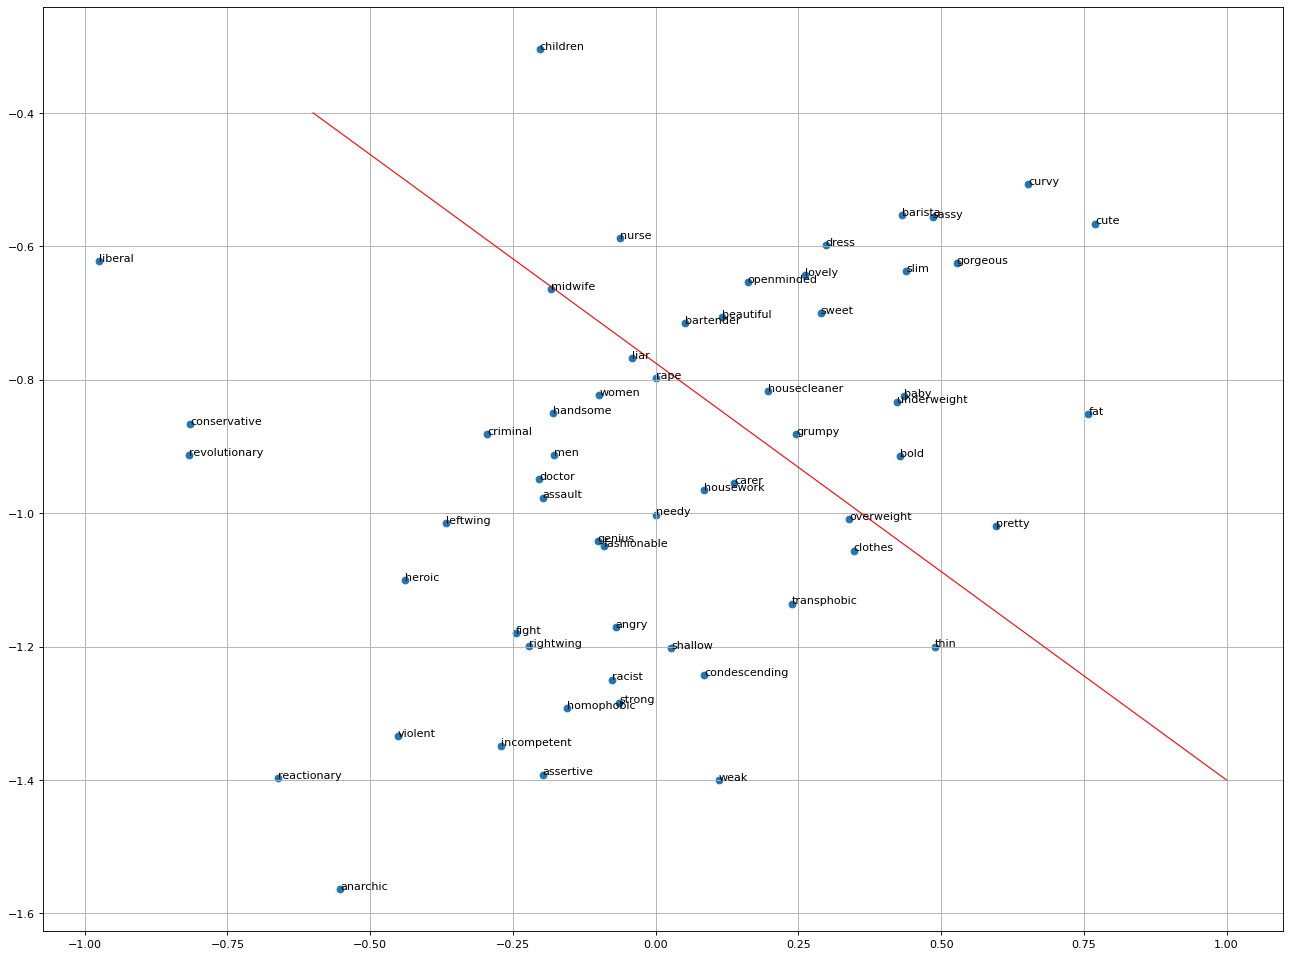

In [ ]:
df2 = df.loc[gender_words] # subset of df only containing the terms in our gender_words list as keys/index

# our two dimensions to be used as coordinates
x = df2[0] 
y = df2[1]

# just some size adjustment...
fig = plt.figure(figsize = (20, 15),dpi=80)

# plot x and y
plt.scatter(x,y)

# add labels to the dots so we know what each of them refers to
for i, txt in enumerate(gender_words):
    plt.annotate(txt, (x[i], y[i]))

# add a grid to help understand distances a bit better
plt.grid()

# plot a diagonal red line (this was added after having interepreted the plot already, for ease of visualization)
# it can be skipped, of course
plt.plot([-0.6,1], [-0.4, -1.4], 'red', linewidth=1)

#show the plot
plt.show()